# (phase 2) 04 Domain shift quantification

The first step in the transfer learning process is to understand the shift between source and target domains. To this end, three different approaches are assessed in this notebook:

- 1. Discriminative distance between domains
- 2. Novelty detection
- 3. Statistical distance

As a fourth step, the label shift will be investigated as well:
- 4. Label shift

Note: the concept drift shift is not investigated, as a key aspect of the study is the assumption of RSV positivity behaving equivalently in source and target domains. Thus the P(y|X) is assumed to be kept: P_target(y|X) = P_source(y|X)

In [222]:
import os
import numpy as np
import pandas as pd
import importlib
import joblib
from sklearn.neighbors import BallTree
import prince
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp, chi2_contingency, entropy
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *
from auxFuns.transfer_learning import *

In [221]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

import auxFuns.transfer_learning
importlib.reload(auxFuns.transfer_learning)

<module 'auxFuns.transfer_learning' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\transfer_learning.py'>

## 0. Motivation for transfer learning

Before jumping directly on the characterization of the domain shift, let us set the stage: why is relevant to implement transfer learning in this case.

In [3]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

# Phase 1 data
rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_phase1_df = make_it_categorical_v2(rsv_predictors_df_v2)

# Phase 2 data
rsv_phase2_df = pd.read_csv(processed_datasets_path + '/rsv_phase2_all_features.csv',low_memory=False)
rsv_phase2_df = make_it_categorical_v2(rsv_phase2_df, is_phase1 = False)

# Small subset of labelled data of phase 2:
labels_phase2_df = pd.read_csv(raw_datasets_path + '/rsv_test_phase2.csv',low_memory=False)
labels_phase2_df = labels_phase2_df.rename(columns = {'RSV_test_date':'index_date'})

# Compatibility issue detected: merging labelled and unlabelled data is challening due to incompatible date columns
rsv_phase2_df.index_date = pd.to_datetime(rsv_phase2_df.index_date)
labels_phase2_df.index_date = pd.to_datetime(labels_phase2_df.index_date)

rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id', 'index_date'])
# rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id'])
rsv_phase2_labelled_df = rsv_phase2_labelled_df.dropna()

rsv_predictors_phase1_df.shape, rsv_phase2_df.shape, rsv_phase2_labelled_df.shape

((86058, 64), (291938, 63), (2867, 64))

In [4]:
# Only 2003 of the 3073 (~65%) patients who underwent a RSV test are present in the whole populations's dataset
patient_ids_rsv_test = labels_phase2_df.patient_id.unique()
patient_ids_phase2 = rsv_phase2_df.patient_id.unique()

len(patient_ids_rsv_test), len(patient_ids_phase2), (pd.Series(patient_ids_rsv_test).isin(patient_ids_phase2)).sum()

(3073, 40507, 2003)

In [5]:
# This agrees with the results of the previous check
unique_patients_rsv_test = len(rsv_phase2_labelled_df.patient_id.unique())
print(f'Number of unique patients with a rsv test in phase 2 data: {unique_patients_rsv_test}')

negative_tests = rsv_phase2_labelled_df.RSV_test_result.value_counts()[0]
positive_tests = rsv_phase2_labelled_df.RSV_test_result.value_counts()[1]
IR_phase2 = negative_tests / positive_tests
p_pos_phase2 = (positive_tests / (positive_tests + negative_tests))*100
print(f'\nImbalance ratio in the phase 2 labelled data: {IR_phase2}')
print(f'Percentage of positives phase 2: {p_pos_phase2}')
# the imbalance is heavier than in phase 1 (1.8% of positives vs ~3.0% in phase 1)

Number of unique patients with a rsv test in phase 2 data: 1717

Imbalance ratio in the phase 2 labelled data: 54.13461538461539
Percentage of positives phase 2: 1.8137425880711544


In [6]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v2_aux = selected_features_v2.copy()
selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [7]:
df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v2]
df_modelling_phase2 = rsv_phase2_labelled_df[selected_features_v2]
df_modelling_all_phase2 = rsv_phase2_df[selected_features_v2_aux]

# differentiate between labelled and non-labelled data in phase 2
labelled_data_phase2_mask = rsv_phase2_labelled_df.index
labelled_mask = rsv_phase2_df.index.isin(labelled_data_phase2_mask)
non_labelled_mask = ~rsv_phase2_df.index.isin(labelled_data_phase2_mask)

df_phase2_labelled = df_modelling_phase2.copy()
df_phase2_unlabelled = df_modelling_all_phase2.loc[non_labelled_mask,:]

df_modelling_phase1.shape, df_phase2_labelled.shape, df_phase2_unlabelled.shape

((86058, 21), (2867, 21), (289071, 20))

Motivation for transfer learning: evaluation of the performance of the previously developed model in the phase 2 population

In [9]:
# Loading the previously-validated models from phase 1
phase1_models_path = os.getcwd() + '/models/models_phase1'

model_nonOverlapping_phase1 = joblib.load(phase1_models_path + '/nonOverlapping_rfc_8020_20230903.joblib')
model_Overlapping_phase1 = joblib.load(phase1_models_path + '/Overlapping_rfc_8020_20230903.joblib')

In [11]:
# Division of phase 2 population into overlapping and non-overlapping regions
# Divide the data in overlapping and non overlapping
X_test_phase2 =  pd.get_dummies(df_modelling_phase2.drop(['RSV_test_result'], axis = 1))
y_test_phase2 = df_modelling_phase2['RSV_test_result']

same_class_neighbours_phase2_dict, __, __, __ = calculate_same_neighbours_and_N1(X_test_phase2 ,y_test_phase2, n_neighbours = 2)
same_class_neighbours_phase2 = same_class_neighbours_phase2_dict[1]

X_test_phase2_nonOverlapping = X_test_phase2.loc[same_class_neighbours_phase2 == True,:]
X_test_phase2_Overlapping = X_test_phase2.loc[same_class_neighbours_phase2 == False,:]

y_test_phase2_nonOverlapping = y_test_phase2.loc[same_class_neighbours_phase2 == True]
y_test_phase2_Overlapping = y_test_phase2.loc[same_class_neighbours_phase2 == False]

y_test_phase2_nonOverlapping.value_counts(), y_test_phase2_Overlapping.value_counts()

Build-up of the ball tree ...
Finding closest 1 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.029647715381932338
Done!


(Negative    2770
 Positive      12
 Name: RSV_test_result, dtype: int64,
 Negative    45
 Positive    40
 Name: RSV_test_result, dtype: int64)

In [13]:
# Now, calculate the performance metrics of every region
# Non-overlapping
print('----------------------------------')
print('Non-overlapping region performance')

preds_proba_nonOverlapping = model_nonOverlapping_phase1.predict_proba(X_test_phase2_nonOverlapping)[:,1]
optimal_thr_nonOverlapping = find_optimal_moving_threshold_from_probas(preds_proba_nonOverlapping, y_test = y_test_phase2_nonOverlapping)
__, __, __, __, __, __, __, __, __,__,__,__ = calculate_performance_metrics_from_probas(y_probs = preds_proba_nonOverlapping, y_test = y_test_phase2_nonOverlapping, 
                                                                            threshold = optimal_thr_nonOverlapping, print_roc = False, print_pr = False)

print('\n----------------------------------')
print('(yes) Overlapping region performance')

preds_proba_Overlapping = model_Overlapping_phase1.predict_proba(X_test_phase2_Overlapping)[:,1]
optimal_thr_Overlapping = find_optimal_moving_threshold_from_probas(preds_proba_Overlapping, y_test = y_test_phase2_Overlapping)
__, __, __, __, __, __, __, __, __,__,__,__ = calculate_performance_metrics_from_probas(y_probs = preds_proba_Overlapping, y_test = y_test_phase2_Overlapping, 
                                                                            threshold = optimal_thr_Overlapping, print_roc = False, print_pr = False)

print('\n----------------------------------')
print('Aggregated metrics')
probs_all = np.concatenate([preds_proba_nonOverlapping, preds_proba_Overlapping], axis = 0)
y_test_all = pd.concat([y_test_phase2_nonOverlapping,y_test_phase2_Overlapping], axis = 0)

optimal_thr_all = find_optimal_moving_threshold_from_probas(probs_all, y_test = y_test_all)
__, __, __, __, __, __, __, __, __,__,__,__ = calculate_performance_metrics_from_probas(y_probs = probs_all, y_test = y_test_all, 
                                                                            threshold = optimal_thr_all, print_roc = False, print_pr = False)

----------------------------------
Non-overlapping region performance
Optimal threshold: 0.58
Optimal f1: 0.028125


AUC Score: 0.7468261131167269
Precision / Positive predictive value: 0.014331210191082803
Specificity: 0.7765342960288809
Recall / sensitivity: 0.75
Negative predictive value: 0.9986072423398329
Accuracy: 0.7764198418404026
F-1: 0.028125
Precision-Recall AUC: 0.008571309282617987

----------------------------------
(yes) Overlapping region performance
Optimal threshold: 0.0
Optimal f1: 0.6399999999999999


AUC Score: 0.4611111111111111
Precision / Positive predictive value: 0.47058823529411764
Specificity: 0.0
Recall / sensitivity: 1.0
Negative predictive value: nan
Accuracy: 0.47058823529411764
F-1: 0.6399999999999999
Precision-Recall AUC: 0.45122814486149265

----------------------------------
Aggregated metrics


c:\Users\angel\Documents\VSCode\rsv_modelling_transfer_learning\auxFuns\modelling.py:794: RuntimeWarning: invalid value encountered in longlong_scalars
  npv = tn / (tn + fn)


Optimal threshold: 0.04
Optimal f1: 0.07917656373713382


AUC Score: 0.7105649678917885
Precision / Positive predictive value: 0.04128819157720892
Specificity: 0.5875666074600355
Recall / sensitivity: 0.9615384615384616
Negative predictive value: 0.998792270531401
Accuracy: 0.5943494942448553
F-1: 0.07917656373713382
Precision-Recall AUC: 0.03754159143412433


**Motivation for transfer learning:** As suspected, the model developed in phase 1 fails to generalize for phase 2 population.

Interestengly enough, the model from phase 1 is biased to positive instances. This leads to excelent recall values (~90% of positive samples are identified) while low performing precision values (~4% of positives are true positives).

## 1. Domain shift quantification: discriminative distance
This approach consists on the training of a classifier which aims to differentiate between a point belonging to the source or target domain. Then, the error of the training set gives a measure of how easy it is to differentiate between both domains.

[3] Mu, Y., Ding, W., & Tao, D. (2013). Local discriminative distance metrics ensemble learning. Pattern Recognition, 46(8), 2337-2349.


In [77]:
# differentiate between labelled and non-labelled data in phase 2
labelled_data_phase2_mask = rsv_phase2_labelled_df.index
labelled_mask = rsv_phase2_df.index.isin(labelled_data_phase2_mask)
non_labelled_mask = ~rsv_phase2_df.index.isin(labelled_data_phase2_mask)

df_modelling_all_phase2.loc[non_labelled_mask, 'phase'] = '2_No_label'
df_modelling_all_phase2.loc[labelled_mask, 'phase'] = '2_label'
df_modelling_phase1.loc[:,'phase'] = ['1']*df_modelling_phase1.shape[0]

df_modelling_both_phases = pd.concat([df_modelling_phase1, df_modelling_all_phase2], axis = 0)

df_modelling_both_phases.loc[:,'phase_v2'] = [1 if phase_label == '1' else 2 for phase_label in df_modelling_both_phases.phase]
# df_modelling_both_phases.phase_v2.value_counts()

# Ensure there is no phase-related information in the Discriminative information data
df_modelling_DA = df_modelling_both_phases.drop(['RSV_test_result', 'phase'], axis = 1)

# Drop the features that are not related to phase 2 and see the results
rsv_test_related_features = ['n_tests_that_day', 'previous_test_daydiff', 'multiple_tests']
df_modelling_DA_no_extra_features = df_modelling_DA.drop(rsv_test_related_features, axis = 1)

X_modelling_DA_no_extra_features = pd.get_dummies(df_modelling_DA_no_extra_features.drop(['phase_v2'], axis = 1))
X_modelling_DA_normal = pd.get_dummies(df_modelling_DA.drop(['phase_v2'], axis = 1))

labels_DA = df_modelling_DA['phase_v2']

C:\Users\angel\AppData\Local\Temp\ipykernel_1944\1451816106.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelling_phase1.loc[:,'phase'] = ['1']*df_modelling_phase1.shape[0]


In [82]:
DA_dictionary_normal = {
    'model': [RandomForestClassifier(), LogisticRegression(), DecisionTreeClassifier(), GradientBoostingClassifier()],
    'error_rate': [0, 0, 0, 0],
    'accuracy': [0, 0, 0, 0],
    'y_probs': [None, None, None, None],
    'precision': [0, 0, 0, 0],
    'recall': [0, 0, 0, 0],
    'f1_score': [0, 0, 0, 0],
    'roc_auc_score': [0, 0, 0, 0]
}
DA_dictionary_no_extra_features = {
    'model': [RandomForestClassifier(), LogisticRegression(), DecisionTreeClassifier(), GradientBoostingClassifier()],
    'error_rate': [0, 0, 0, 0],
    'accuracy': [0, 0, 0, 0],
    'y_probs': [None, None, None, None],
    'precision': [0, 0, 0, 0],
    'recall': [0, 0, 0, 0],
    'f1_score': [0, 0, 0, 0],
    'roc_auc_score': [0, 0, 0, 0]
}

print('\n---------------------------------')
print('Discriminative analysis on source and target with all features')
DA_dictionary_normal = domain_shift_discriminative_analysis(DA_dictionary = DA_dictionary_normal, X_modelling = X_modelling_DA_normal, labels = labels_DA)
print('\n---------------------------------')
print('Discriminative analysis on source and target only with selected features')
DA_dictionary_no_extra_features = domain_shift_discriminative_analysis(DA_dictionary = DA_dictionary_no_extra_features, X_modelling = X_modelling_DA_no_extra_features, labels = labels_DA)



---------------------------------
Discriminative analysis on source and target with all features

Metrics for RandomForestClassifier:
Error rate: 0.0042
Accuracy: 0.9958
Precision: 0.9990
Recall: 0.9955
F1 Score: 0.9973
ROC AUC Score: 0.9987

Metrics for LogisticRegression:
Error rate: 0.7724
Accuracy: 0.2276
Precision: 0.4813
Recall: 0.0013
F1 Score: 0.0025
ROC AUC Score: 0.3844

Metrics for DecisionTreeClassifier:
Error rate: 0.0062
Accuracy: 0.9938
Precision: 0.9962
Recall: 0.9958
F1 Score: 0.9960
ROC AUC Score: 0.9916

Metrics for GradientBoostingClassifier:
Error rate: 0.0046
Accuracy: 0.9954
Precision: 0.9999
Recall: 0.9942
F1 Score: 0.9970
ROC AUC Score: 0.9990

---------------------------------
Discriminative analysis on source and target only with selected features

Metrics for RandomForestClassifier:
Error rate: 0.1614
Accuracy: 0.8386
Precision: 0.8670
Recall: 0.9344
F1 Score: 0.8994
ROC AUC Score: 0.8380

Metrics for LogisticRegression:
Error rate: 0.1700
Accuracy: 0.8300


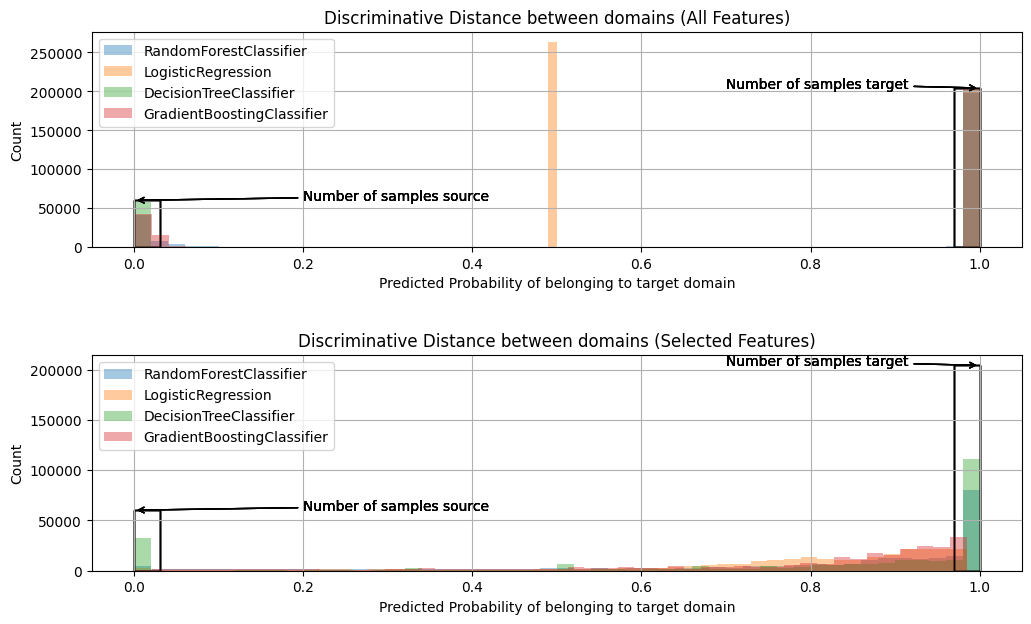

In [124]:
y_test.value_counts()
num_samples_source =60241
num_samples_target = 204357

# Create a figure with horizontally arranged subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

# First subplot: Using all features
for i in range(len(DA_dictionary_normal['model'])):
    model_name = type(DA_dictionary_normal['model'][i]).__name__
    domain_shift_plot_histogram_DA(axs[0], DA_dictionary_normal['y_probs'][i], num_samples_source, num_samples_target, model_name=model_name)
axs[0].set_title('Discriminative Distance between domains (All Features)')

# Second subplot: Using selected features only
for i in range(len(DA_dictionary_no_extra_features['model'])):
    model_name = type(DA_dictionary_no_extra_features['model'][i]).__name__
    domain_shift_plot_histogram_DA(axs[1], DA_dictionary_no_extra_features['y_probs'][i], num_samples_source, num_samples_target, model_name=model_name)
axs[1].set_title('Discriminative Distance between domains (Selected Features)')

plt.subplots_adjust(hspace=0.5)
plt.show()

Discriminant analysis does not bring final conclusions on having very distinct populations, although the randomforest achieved a very high accuracy in differentiating between source and target populations.

The results seem to reveal more about the classifier's ability to model the data rather than the true difference between the domains.

## 2. Domain shift quantification: novelty detection

Novelty detection [4] is a well-known method whose purpose is to model the distribution of the source population and identify if the new points (of the target population) belong or not to that distribution. In this section we will approach both novelty and outlier detection.

Some methods to approach Novelty detection are:
- Isolation forest [5]

[4] Markou, M., & Singh, S. (2003). Novelty detection: a review—part 1: statistical approaches. Signal processing, 83(12), 2481-2497.
[5] Liu, F. T., Ting, K. M., & Zhou, Z. H. (2008, December). Isolation forest. In 2008 eighth ieee international conference on data mining (pp. 413-422). IEEE.

In [ ]:
# Prepare the data for modelling
df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v2]
df_modelling_labelled_phase2 = rsv_phase2_labelled_df[selected_features_v2]
df_modelling_all_phase2 = rsv_phase2_df[selected_features_v2_aux]

print(df_modelling_phase1.shape, df_modelling_labelled_phase2.shape, df_modelling_all_phase2.shape)

df_modelling_labelled_phase2.loc[:,'n_tests_that_day'] = pd.Categorical(df_modelling_labelled_phase2.n_tests_that_day, categories=[1,2])
df_modelling_all_phase2.loc[:,'n_tests_that_day'] = pd.Categorical(df_modelling_all_phase2.n_tests_that_day, categories=[1,2])


# Differentiate between source and target distributions
X_source = df_modelling_phase1.drop(['RSV_test_result'], axis = 1) # source distribution
labels_source = df_modelling_phase1['RSV_test_result']

X_target = df_modelling_all_phase2.copy() # target distribution

X_source.shape, X_target.shape

In [52]:
# Fiting an Isolation Forest to source population
random_seed = 42

# add a contamination of 0.05 to allow for only 5% of outliers
isolationForest_model = IsolationForest(n_estimators=50, max_samples=1000, bootstrap=True, random_state=random_seed, contamination = 0.05)
# isolationForest_model = IsolationForest(n_estimators=50, max_samples=1000, bootstrap=True, random_state=random_seed, contamination = 'auto')
isolationForest_model.fit(pd.get_dummies(X_source))

C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(bootstrap=True, contamination=0.05, max_samples=1000,
                n_estimators=50, random_state=42)

Estimated contamination in the source data: 0.05000116200701852
Estimated contamination in the target data: 0.031938288266686765


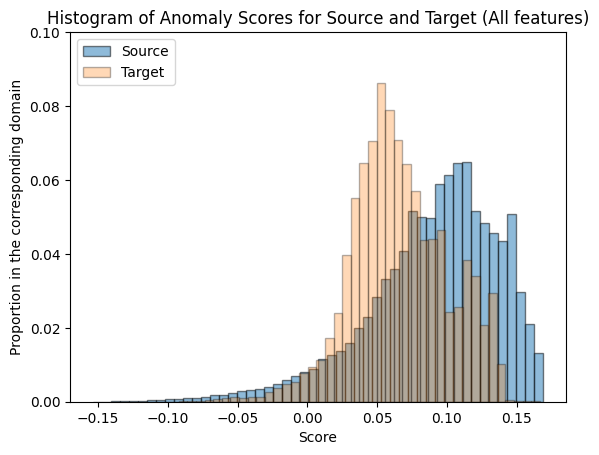

In [125]:
# Anomalies scores in both target and source data
source_data = pd.get_dummies(X_source)
train_preds_source = isolationForest_model.predict(source_data)
estimated_contamination_scores_source = (train_preds_source == -1).sum() / len(source_data)

target_data = pd.get_dummies(X_target)
train_preds_target = isolationForest_model.predict(target_data)
estimated_contamination_scores_target = (train_preds_target == -1).sum() / len(target_data)
print(f"Estimated contamination in the source data: {estimated_contamination_scores_source}")
print(f"Estimated contamination in the target data: {estimated_contamination_scores_target}")

# Plotting of anomalies scores in both source and target
scores_source = isolationForest_model.decision_function(source_data) 
scores_target = isolationForest_model.decision_function(target_data)

n_s, bins_s, patches_s = plt.hist(scores_source, bins=50, alpha=0.5, label='Source', edgecolor='k', density=True)
n_t, bins_t, patches_t = plt.hist(scores_target, bins=50, alpha=0.3, label='Target', edgecolor='k', density=True)

# Convert densities to proportions
bin_width_s = bins_s[1] - bins_s[0]
bin_width_t = bins_t[1] - bins_t[0]

for p in patches_s:
    height = p.get_height()
    p.set_height(height * bin_width_s)

for p in patches_t:
    height = p.get_height()
    p.set_height(height * bin_width_t) 

plt.title("Histogram of Anomaly Scores for Source and Target (All features)")
plt.xlabel("Score")
plt.ylabel("Proportion in the corresponding domain")
plt.ylim(0, 0.1)

plt.legend(loc='upper left')
plt.show()

## 3. Statistical distance 
As a final approach to quantify the domain shit, let us evaluate the statistical distance between the distributions of every feature in both populations. This will be an univariate analysis, so one needs to be cautious with the results. However, it will give a sense of which features are more heavily shifted.

Analyzing feature: n_tests_that_day


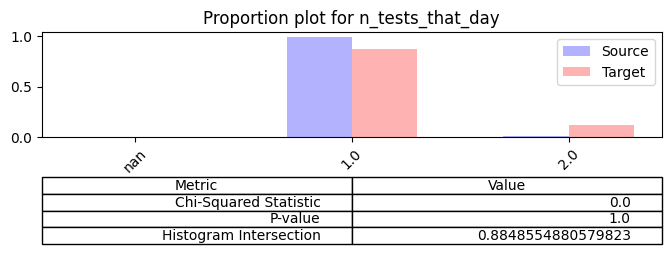





Analyzing feature: sine


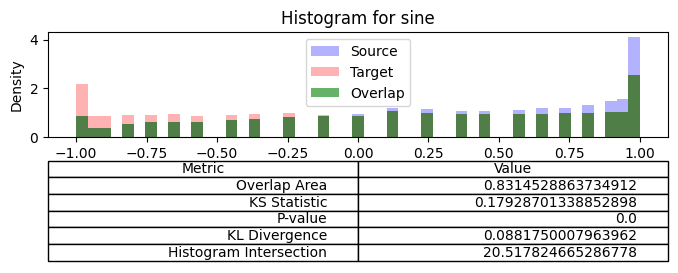





Analyzing feature: cosine


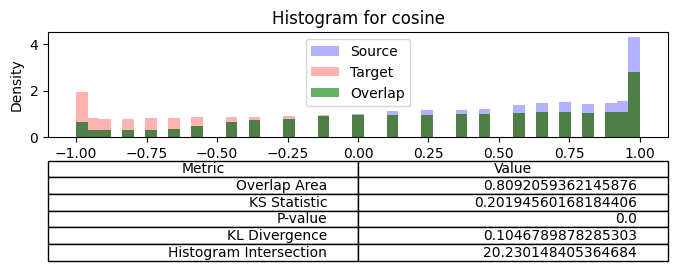





Analyzing feature: previous_test_daydiff


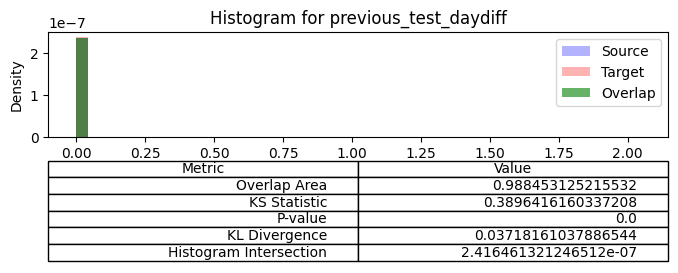





Analyzing feature: Bronchitis


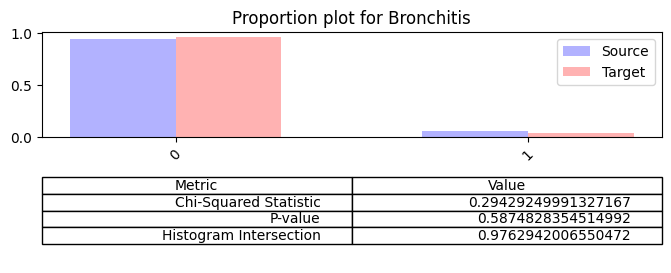





Analyzing feature: CCI


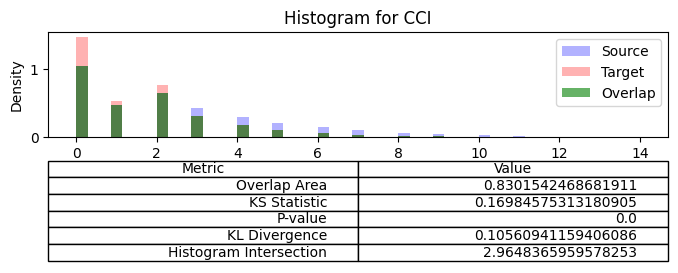





Analyzing feature: Acute_upper_respiratory_infection


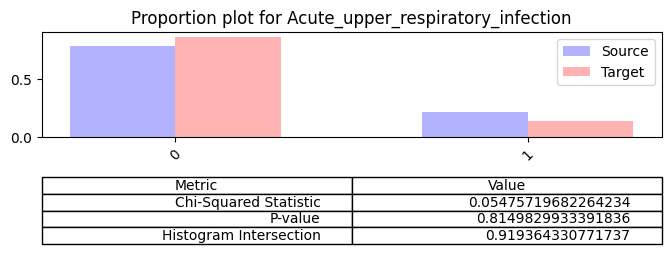





Analyzing feature: n_immunodeficiencies


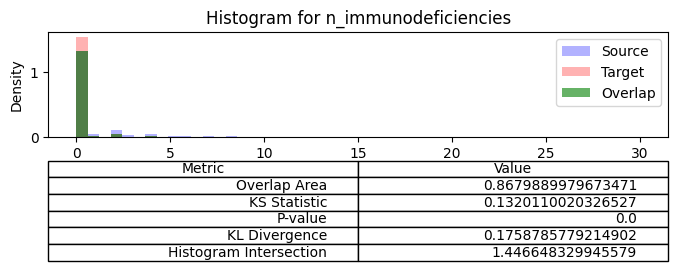





Analyzing feature: n_symptoms


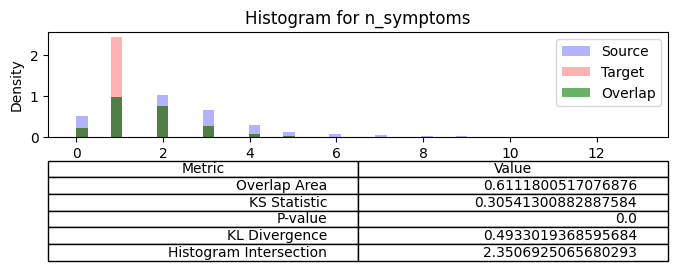





Analyzing feature: healthcare_seeking


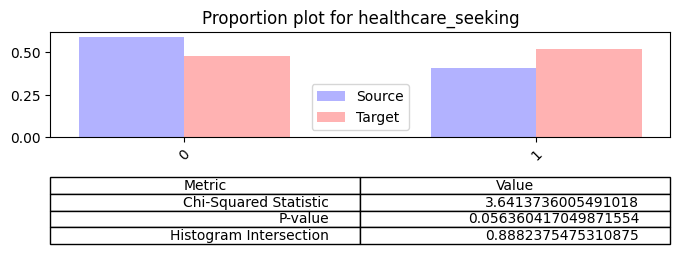





Analyzing feature: General_symptoms_and_signs


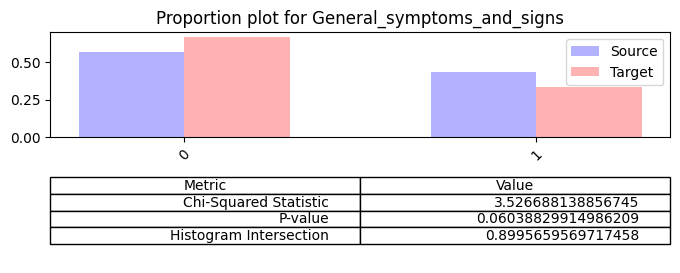





Analyzing feature: prev_positive_rsv


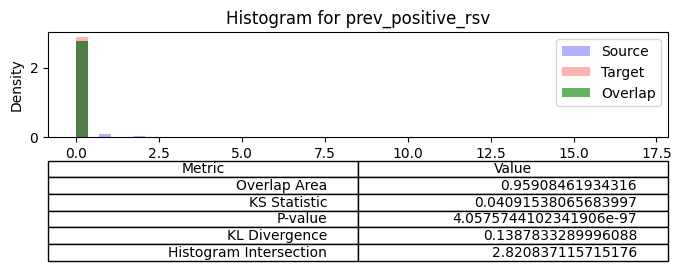





Analyzing feature: Influenza


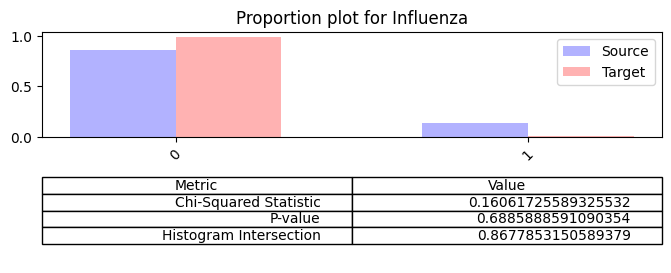





Analyzing feature: key_comorbidities


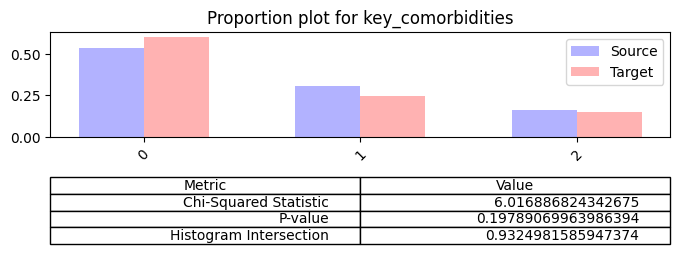





Analyzing feature: Pneumonia


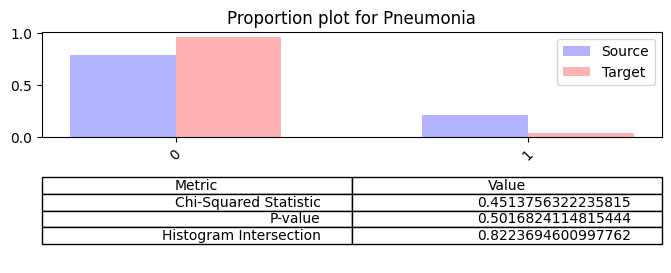





Analyzing feature: season


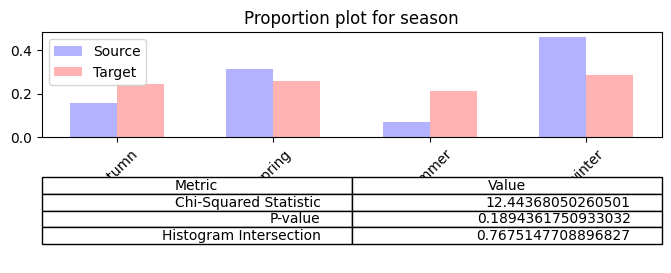





Analyzing feature: month_of_the_test


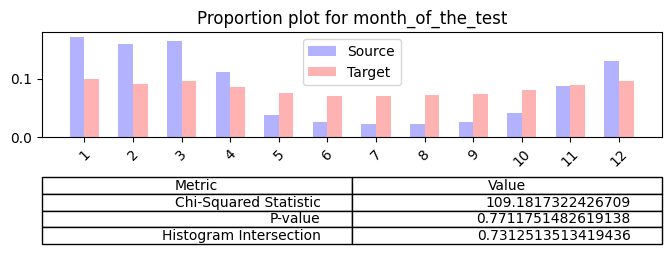





Analyzing feature: multiple_tests


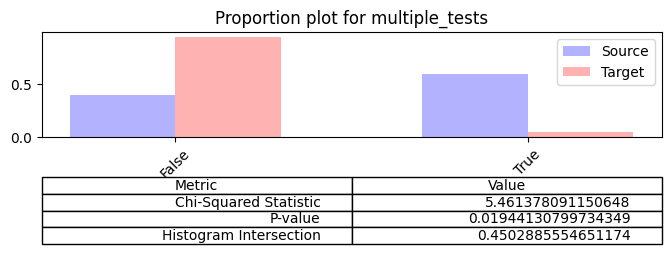





Analyzing feature: BPA


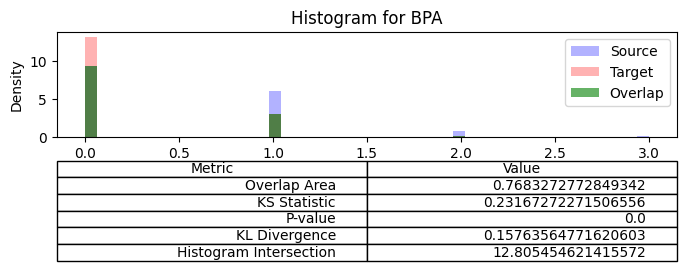





Analyzing feature: BPAI


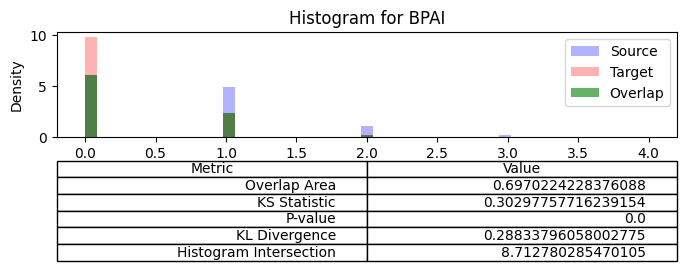

In [148]:
list_of_features = list(X_target.columns)
list_of_categorical_flags = list((X_target.dtypes) == 'category')

for feature, is_categorical in zip(list_of_features, list_of_categorical_flags):
    domain_shift_analyze_feature(X_source, X_target, feature, categorical=is_categorical)

## 4. Label shift 

As a final remark and to finalize the quantification of domain shift, let us visualize the differences between the distribution in the labels of both populations

In [175]:
labels_target = rsv_phase2_labelled_df.RSV_test_result
labels_source = df_modelling_phase1.RSV_test_result

labels_source.value_counts(), labels_target.value_counts()

(Negative    83404
 Positive     2654
 Name: RSV_test_result, dtype: int64,
 Negative    2815
 Positive      52
 Name: RSV_test_result, dtype: int64)

,Source,Target (labelled subset)
# Positives,"2,654",52
# Negatives,"83,404","2,815"
Imbalance ratio,31.43,54.13
# Unique Patients,"48,040","1,717"


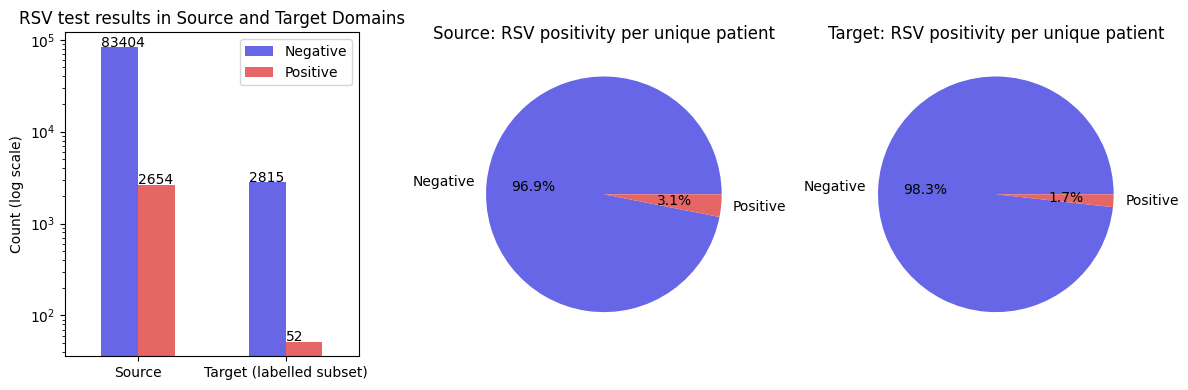

In [223]:
summary_table = domain_shift_create_summary_table_labels(source_data = rsv_predictors_phase1_df, target_data = rsv_phase2_labelled_df, 
                label_column = 'RSV_test_result', patient_id_column = 'patient_id')
display(summary_table)

label_shift_plot_combined_chart(labels_source, labels_target, source_data=rsv_predictors_phase1_df, target_data=rsv_phase2_labelled_df, label_column='RSV_test_result', patient_id_column='patient_id')

There exists a label shift between source and target domain. This has to be adressed together with the existing covariate shift shown above.